Problem 3

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [29]:
strawberry = pd.read_csv('strawberry.csv')
train = strawberry.iloc[:150]
test = strawberry.iloc[150:]

In [30]:
def profit(stock, demand):
    if stock <= demand:
        return 6 * stock - 3 * stock
    else:
        return 6 * demand - 3 * stock + 1.5 * (stock - demand)

Part 1a

$\underset{Q}{minimize} \quad \mathbb{E}[c_u(D-Q)^+ + c_o(Q-D)^+]$

where

Q = order quantity = number of strawberries stocked on a given day

D = demand = number of strawberries demanded on a given day

$c_o$ = overage cost = cost of selling a single extra strawberry = $1.5

$c_u$ = underage cost = cost of buying a single extra strawberry = $3

$q = \frac{c_u}{c_u+c_o}$

$\implies q = \frac{3}{3+1.5}$

$\implies q = 0.666$

In [31]:
# Part 1b

print(f'The optimal constant order quantity for training data is {train.demand.quantile(2/3):.0f}.')

The optimal constant order quantity for training data is 1469.


In [32]:
# Part 1c

train['profit1'] = train.apply(lambda x: profit(train.demand.quantile(2/3), x['demand']), axis=1)
train.profit1.mean()

4074.27

In [33]:
# Part 1d

test['profit1'] = test.apply(lambda x: profit(train.demand.quantile(2/3), x['demand']), axis=1)
test.profit1.mean()

4074.47

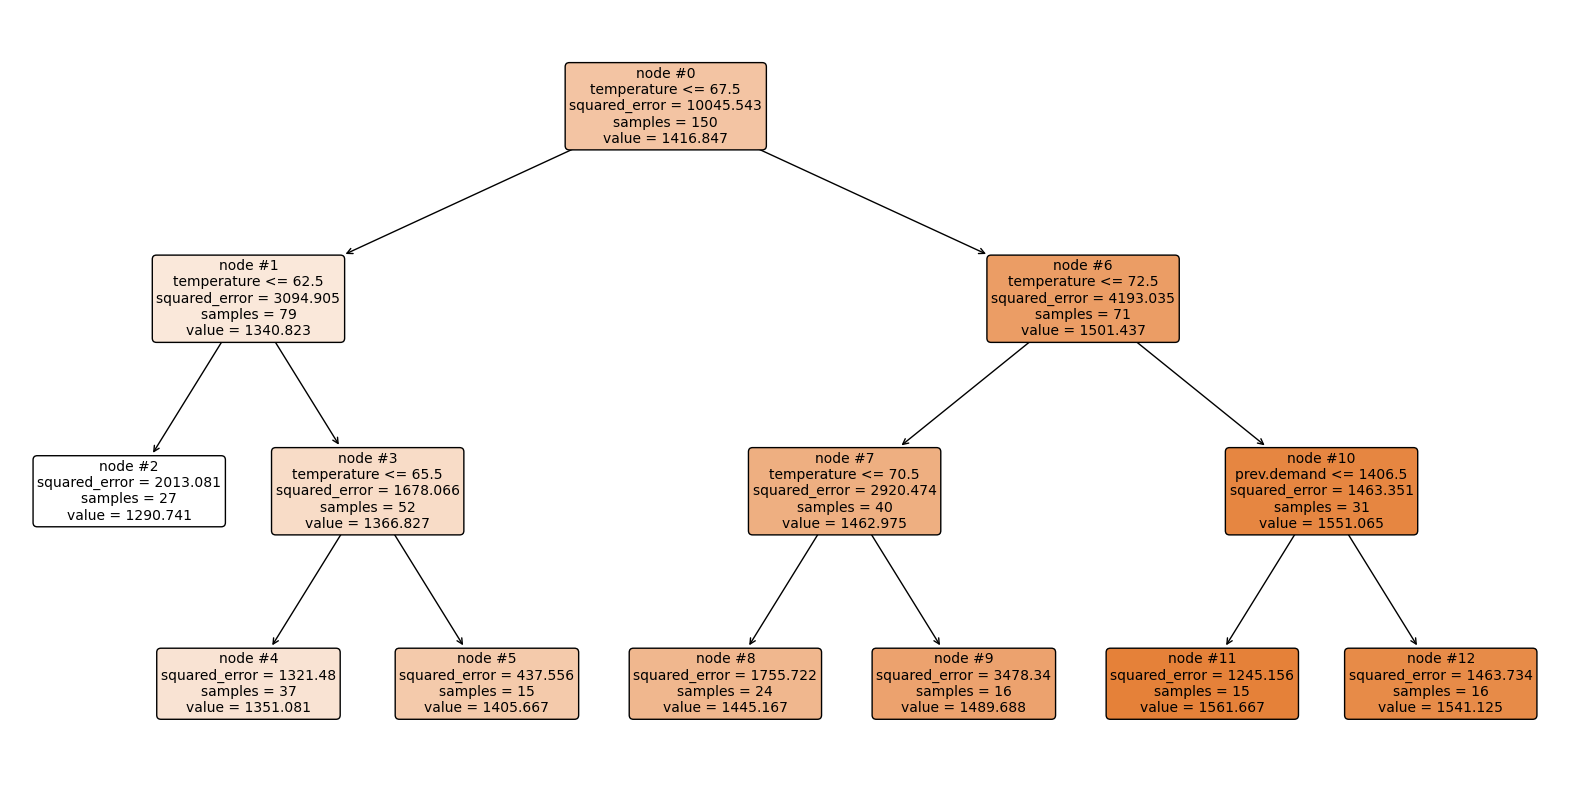

In [34]:
# Part 2a

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
X_train = train[['app.logins', 'temperature', 'prev.demand', 'prev.demand.2']]
y_train = train['demand']
tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=15)
tree.fit(X_train, y_train)
tree_features = X_train.columns[tree.tree_.feature]
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=list(X_train.columns), filled=True, rounded=True, fontsize=10, node_ids=True)
plt.show()

My tree splits on the variables 'temperature' and 'prev.demand'

In [35]:
# Part 2b

leaf_mapping = tree.apply(X_train)

leaves = [i for i in range(tree.tree_.node_count) if tree.tree_.children_left[i] == -1 ]

leaf_to_quantile = np.zeros( tree.tree_.node_count )

nv_quantile = 2/3

for ell in leaves:
    ind = leaf_mapping == ell
    y_ell = y_train[ind]
    leaf_to_quantile[ell] = np.quantile(y_ell, nv_quantile)
    print(f'Node {ell} has proposed order quantity {leaf_to_quantile[ell]:.0f}')

Node 2 has proposed order quantity 1302
Node 4 has proposed order quantity 1369
Node 5 has proposed order quantity 1414
Node 8 has proposed order quantity 1461
Node 9 has proposed order quantity 1510
Node 11 has proposed order quantity 1575
Node 12 has proposed order quantity 1560


In [36]:
# Part 2c

X_test = test[['app.logins', 'temperature', 'prev.demand', 'prev.demand.2']]

test['test_set_leaves'] = tree.apply(X_test)
test['order2'] = test['test_set_leaves'].map(lambda x: leaf_to_quantile[x])

test['profit2'] = test.apply(lambda x: profit(x['order2'], x['demand']), axis=1)
print("Average out-of-sample profit (contextual newvendor):", test['profit2'].mean(axis = 0))

Average out-of-sample profit (contextual newvendor): 4174.85


In [37]:
# Part 3a

from sklearn.linear_model import LinearRegression
X_train = train[['app.logins', 'temperature', 'prev.demand', 'prev.demand.2']]
y_train = train['demand']
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

print("Coefficients:", lin_reg.coef_)
print("Intercept:", lin_reg.intercept_)
print("R^2:", lin_reg.score(X_train, y_train))

Coefficients: [ 0.10899557 19.73334574 -0.07492321  0.08497646]
Intercept: 64.01934679788383
R^2: 0.8491786123388362


In [38]:
# Part 3b

X_test = test[['app.logins', 'temperature', 'prev.demand', 'prev.demand.2']]
predictions_mean = lin_reg.predict(X_test)
residuals = y_train - lin_reg.predict(X_train)
percentile_66 = np.percentile(residuals, 66.6)
test['order3'] = predictions_mean + percentile_66
test['profit3'] = test.apply(lambda x: profit(x['order3'], x['demand']), axis=1)
test.profit3.mean()

4181.509329122083

In [39]:
# Part 4a

test['order4'] = test['demand']
test['profit4'] = test.apply(lambda x: profit(x['order4'], x['demand']), axis=1)
test.profit4.mean()

4246.68

In [40]:
# Part 4b

Rconstant = test.profit1.mean()
Ridealized = test.profit4.mean()

Rcontextual = test.profit2.mean()
c_p2 = (Rcontextual - Rconstant) / (Ridealized - Rconstant)

Rcontextual = test.profit3.mean()
c_p3 = (Rcontextual - Rconstant) / (Ridealized - Rconstant)

c_p2, c_p3

(0.5828929795017727, 0.621562796133109)

Part 4c

The metric is R^2. The coefficient of prescriptiveness is similar to R^2 in that it measures the proportion of the variance in the dependent variable that is predictable from the independent variables.